In [1]:
%matplotlib inline

from shared_content import *

In [2]:
# Do you want to write figures to png files? Careful, it will overwrite!
write_figures = True
figdir = 'Figures/'

#anatype = 'MCBNBMCTrack'
anatype = 'MCBNBRecoTrack'

In [3]:
seglen = 10
filedir = 'anafiles/'

df_dict = {}

myfile = 'MCSBiasStudy_%s_anaout_%dcmseg_2res_bothscatters_nonrelfix.root' %( anatype, seglen )
df_dict[anatype], dummy = get_dfs(filedir+myfile)

In [4]:
#reco-true/true
def fractional_bias_plot(xvar = 'full_range_momentum', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_momentum', slicevar = 'full_range_momentum',
                         plot_bin_distributions = False, extraqueries = None, slicetitlebase = None,
                        slicebins = np.linspace(-0.8,.8,20),
                        biasplotname = None, resplotname = None, biasmainfig_ylims = None,
                         resmainfig_ylims = None,
                        usegausfit = False):
    
    plt.figure(figsize=(10,6))
    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)

    if extraqueries is None:
        print "NEED TO DEFINE EXTRA QUERIES PLEASE"
        return False
    
    for extraquery in extraqueries:
        
        myreses, mystds, myerrs_bias, myerrs_res = [], [], [], []
    
        for x in xrange(len(binning)-1):
            
            binmin = binning[x]
            binmax = binning[x+1]
            #print "binmin = %0.2f, binmax = %0.2f"% ( binmin, binmax )
            myquery = '%s > %f and %s < %f'%(slicevar,binmin,slicevar,binmax)
            myquery += ' and '
            myquery += extraquery
                
                
            mydf = df_dict[anatype].query(myquery)
            true = mydf[xvar].values
            reco = mydf[yvar].values
            mymean = ((reco-true)/true).mean()
            mystd = ((reco-true)/true).std()
            
            if plot_bin_distributions:

                datahist = np.histogram((reco-true)/true,bins=slicebins)

                # Plot gaussian on each bin distribution
                if usegausfit:
                     
                    slicebinvals = datahist[0]
                    slicebincenters = [ datahist[1][x] + (datahist[1][x+1]-datahist[1][x])/2 for x in xrange(len(datahist[1])-1) ]
        
                    # Fit a normal distribution
                    gmod = Model(gaussian)
                    #initial random guesses of 1, 1, 2
                    result = gmod.fit(slicebinvals, x=slicebincenters, amp=1, cen=1, wid=2)
    
                    thisx = np.linspace(np.min(slicebins),np.max(slicebins),100)
                    thisy = gaussian(thisx, result.params['amp'], result.params['cen'], result.params['wid'])

                    # If use gaus fit, use the result of that instead of straight mean and RMS
                    mymean = result.params['cen']
                    #Somehow when there are like 2 data points you get a negative width?!
                    mystd  = np.abs(result.params['wid'])
                    # If the fit doesn't converge, 'wid' will be the initial guess of 2.0... don't use these points then
                    # (this only happens when no entries in the sliced histogram)
                    if int(result.params['wid']) == 2:
                        print "WARNING: FIT DIDN'T CONVERGE!"
                        mymean = ((reco-true)/true).mean()
                        mystd = ((reco-true)/true).std()
        
            myerr_bias = mystd / np.sqrt( float(len(true)) )
            myerr_res = mystd / np.sqrt( float(2*len(true)) )
            myreses.append( mymean )
            mystds.append( mystd )
            myerrs_bias.append( myerr_bias )
            myerrs_res.append( myerr_res )
            
            
        #BIAS PLOT    
        plt.errorbar(bincenters[:-1],myreses,yerr=myerrs_bias,xerr=binwidth/2,fmt='o',label='%s'%extraquery)
    plt.ylabel('GausMean($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
    plt.xlabel('%s'%titles[slicevar],fontsize=15)
    plt.grid(True)
    plt.legend(loc='best',fontsize=10)
    t = plt.title('Fractional Bias for Various Angle Bins',fontsize=16)
    t.set_y(1.04)
    if biasmainfig_ylims is not None:
        blah = plt.ylim(biasmainfig_ylims)
    if write_figures and biasplotname is not None:
        print " \n\n Writing the main bias figure!! %s\n\n" % (figdir+biasplotname)
        plt.tight_layout()
        plt.savefig(figdir + biasplotname)

In [5]:
#reco-true/true
def fractional_resolution_plot(xvar = 'full_range_momentum', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_momentum', slicevar = 'full_range_momentum',
                         plot_bin_distributions = False, extraqueries = None, slicetitlebase = None,
                        slicebins = np.linspace(-0.8,.8,20),
                        biasplotname = None, resplotname = None, biasmainfig_ylims = None,
                         resmainfig_ylims = None,
                        usegausfit = False):
    
    plt.figure(figsize=(10,6))
    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)

    if extraqueries is None:
        print "NEED TO DEFINE EXTRA QUERIES PLEASE"
        return False
    
    for extraquery in extraqueries:
        
        myreses, mystds, myerrs_bias, myerrs_res = [], [], [], []
    
        for x in xrange(len(binning)-1):
            
            binmin = binning[x]
            binmax = binning[x+1]
            #print "binmin = %0.2f, binmax = %0.2f"% ( binmin, binmax )
            myquery = '%s > %f and %s < %f'%(slicevar,binmin,slicevar,binmax)
            myquery += ' and '
            myquery += extraquery
                
            mydf = df_dict[anatype].query(myquery)
            true = mydf[xvar].values
            reco = mydf[yvar].values
            mymean = ((reco-true)/true).mean()
            mystd = ((reco-true)/true).std()
            
            if plot_bin_distributions:

                datahist = np.histogram((reco-true)/true,bins=slicebins)

                # Plot gaussian on each bin distribution
                if usegausfit:
                     
                    slicebinvals = datahist[0]
                    slicebincenters = [ datahist[1][x] + (datahist[1][x+1]-datahist[1][x])/2 for x in xrange(len(datahist[1])-1) ]
        
                    # Fit a normal distribution
                    gmod = Model(gaussian)
                    #initial random guesses of 1, 1, 2
                    result = gmod.fit(slicebinvals, x=slicebincenters, amp=1, cen=1, wid=2)
    
                    thisx = np.linspace(np.min(slicebins),np.max(slicebins),100)
                    thisy = gaussian(thisx, result.params['amp'], result.params['cen'], result.params['wid'])

                    # If use gaus fit, use the result of that instead of straight mean and RMS
                    mymean = result.params['cen']
                    #Somehow when there are like 2 data points you get a negative width?!
                    mystd  = np.abs(result.params['wid'])
                    # If the fit doesn't converge, 'wid' will be the initial guess of 2.0... don't use these points then
                    # (this only happens when no entries in the sliced histogram)
                    if int(result.params['wid']) == 2:
                        print "WARNING: FIT DIDN'T CONVERGE!"
                        mymean = ((reco-true)/true).mean()
                        mystd = ((reco-true)/true).std()
        
            myerr_bias = mystd / np.sqrt( float(len(true)) )
            myerr_res = mystd / np.sqrt( float(2*len(true)) )
            myreses.append( mymean )
            mystds.append( mystd )
            myerrs_bias.append( myerr_bias )
            myerrs_res.append( myerr_res )
            
            
        #BIAS PLOT    
        plt.errorbar(bincenters[:-1],mystds,yerr=myerrs_bias,xerr=binwidth/2,fmt='o',label='%s'%extraquery)
    plt.ylabel('GausWidth($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
    plt.xlabel('%s'%titles[slicevar],fontsize=15)
    plt.grid(True)
    plt.legend(loc='best',fontsize=10)
    t = plt.title('Fractional Momentum Resolution for Various Angle Bins',fontsize=16)
    t.set_y(1.04)
    if resmainfig_ylims is not None:
        blah = plt.ylim(resmainfig_ylims)
    if write_figures and resplotname is not None:
        print " \n\n Writing the main res figure!! %s\n\n" % (figdir+resplotname)
        plt.tight_layout()
        plt.savefig(figdir + resplotname)

 

 Writing the main bias figure!! Figures/MCS_range_bias_anglestudy_xangle.png


 

 Writing the main res figure!! Figures/MCS_range_resolution_anglestudy_xangle.png


 

 Writing the main bias figure!! Figures/MCS_range_bias_anglestudy_yangle.png


 

 Writing the main res figure!! Figures/MCS_range_resolution_anglestudy_yangle.png




/Library/Python/2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Library/Python/2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


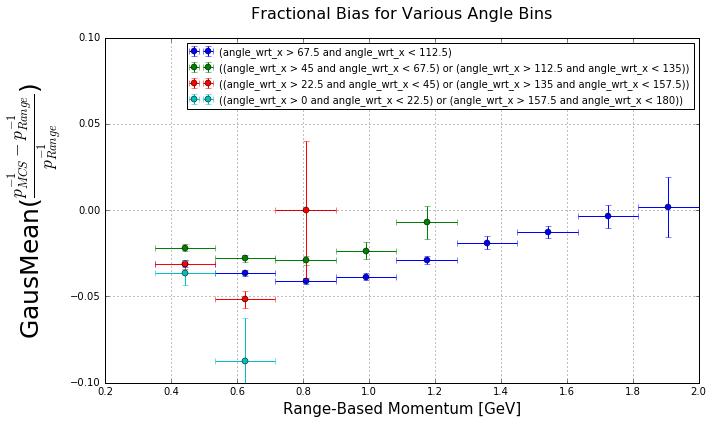

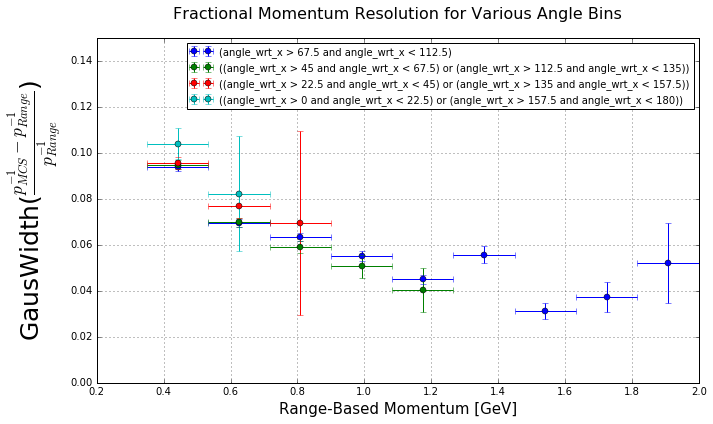

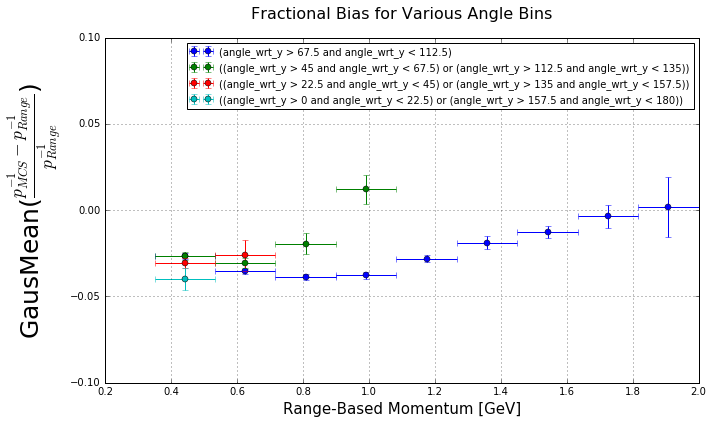

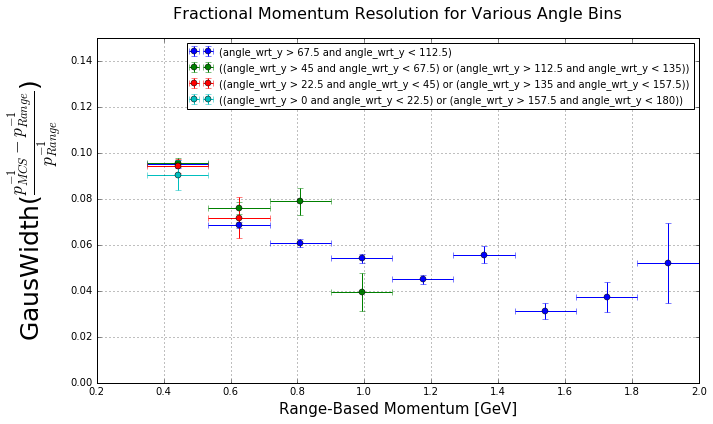

In [6]:
extraqueries = ['(angle_wrt_x > 67.5 and angle_wrt_x < 112.5)',
                '((angle_wrt_x > 45 and angle_wrt_x < 67.5) or (angle_wrt_x > 112.5 and angle_wrt_x < 135))',
                '((angle_wrt_x > 22.5 and angle_wrt_x < 45) or (angle_wrt_x > 135 and angle_wrt_x < 157.5))',
                '((angle_wrt_x > 0 and angle_wrt_x < 22.5) or (angle_wrt_x > 157.5 and angle_wrt_x < 180))']

fractional_bias_plot(xvar='full_range_momentum_inverse',yvar='full_MCS_momentum_inverse',
                     xbins=np.linspace(0.35,2,10),
                       plot_bin_distributions = True,
                       slicevar = 'full_range_momentum',
                       slicetitlebase = None,
                     extraqueries = extraqueries,
                       slicebins = np.linspace(-0.8,0.8,50),
                       biasplotname = 'MCS_range_bias_anglestudy_xangle.png',
                       biasmainfig_ylims = (-.10,.10),
                        usegausfit = True)

fractional_resolution_plot(xvar='full_range_momentum_inverse',yvar='full_MCS_momentum_inverse',
                     xbins=np.linspace(0.35,2,10),
                       plot_bin_distributions = True,
                       slicevar = 'full_range_momentum',
                       slicetitlebase = None,
                        extraqueries = extraqueries,
                       slicebins = np.linspace(-0.8,0.8,50),
                       resplotname = 'MCS_range_resolution_anglestudy_xangle.png',
                       resmainfig_ylims = (0,.15),
                        usegausfit = True)
extraqueries = ['(angle_wrt_y > 67.5 and angle_wrt_y < 112.5)',
                '((angle_wrt_y > 45 and angle_wrt_y < 67.5) or (angle_wrt_y > 112.5 and angle_wrt_y < 135))',
                '((angle_wrt_y > 22.5 and angle_wrt_y < 45) or (angle_wrt_y > 135 and angle_wrt_y < 157.5))',
                '((angle_wrt_y > 0 and angle_wrt_y < 22.5) or (angle_wrt_y > 157.5 and angle_wrt_y < 180))']

fractional_bias_plot(xvar='full_range_momentum_inverse',yvar='full_MCS_momentum_inverse',
                     xbins=np.linspace(0.35,2,10),
                       plot_bin_distributions = True,
                       slicevar = 'full_range_momentum',
                       slicetitlebase = None,
                     extraqueries = extraqueries,
                       slicebins = np.linspace(-0.8,0.8,50),
                       biasplotname = 'MCS_range_bias_anglestudy_yangle.png',
                       biasmainfig_ylims = (-.10,.10),
                        usegausfit = True)

fractional_resolution_plot(xvar='full_range_momentum_inverse',yvar='full_MCS_momentum_inverse',
                     xbins=np.linspace(0.35,2,10),
                       plot_bin_distributions = True,
                       slicevar = 'full_range_momentum',
                       slicetitlebase = None,
                        extraqueries = extraqueries,
                       slicebins = np.linspace(-0.8,0.8,50),
                       resplotname = 'MCS_range_resolution_anglestudy_yangle.png',
                       resmainfig_ylims = (0,.15),
                        usegausfit = True)

In [ ]:
df_dict['MCBNBMCTrack'].hist('angle_wrt_x')

In [ ]:
print df_dict[]

In [ ]:
#"*_publicplot" images won't have and MCTrack stuff in it

dummy = df_dict.pop('MCBNBMCTrack',None)
if 'MCBNBMCTrack' in anatypes:
    anatypes.remove('MCBNBMCTrack')


fractional_bias_plot(xvar='full_range_momentum_inverse',yvar='full_MCS_momentum_inverse',
                     xbins=np.linspace(0.35,1.26666667,6),
                       plot_bin_distributions = True,
                       slicevar = 'full_range_momentum',
                       slicetitlebase = None,
                       slicebins = np.linspace(-0.8,0.8,50),
                       biasplotname = 'MCS_range_bias_multiplesamples_publicplot.png',
                       biasmainfig_ylims = (-.10,.10),
                        usegausfit = True)

fractional_resolution_plot(xvar='full_range_momentum_inverse',yvar='full_MCS_momentum_inverse',
                     xbins=np.linspace(0.35,1.26666667,6),
                       plot_bin_distributions = True,
                       slicevar = 'full_range_momentum',
                       slicetitlebase = None,
                       slicebins = np.linspace(-0.8,0.8,50),
                       resplotname = 'MCS_range_resolution_multiplesamples_publicplot.png',
                       resmainfig_ylims = (0,.15),
                        usegausfit = True)